In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from utils import *

2023-06-21 22:33:32.136094: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-21 22:33:32.163173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 22:33:32.575975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


importing Jupyter notebook from utils.ipynb


In [2]:
df_train = pd.read_csv(train_csv_path, sep=",")
df_train["img_path"] =  df_train['image_id'].apply(build_image_path, convert_dtype=str)

df_test = pd.read_csv(test_csv_path, sep=",")
df_test["img_path"] =  df_test['image_id'].apply(build_image_path, convert_dtype=str)

In [3]:
# Vamos separar os dados em treinamento e validação na proporção 80/20:
df_train_split, df_val_split = train_test_split(df_train, test_size = 0.2, random_state = 123456, stratify = df_train[['cancer']])

print("Número de imagens no conjunto de treinamento: ", df_train_split.shape[0])
print("Distribuição de cancer conjunto de treinamento: ", df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de validação: ", df_val_split.shape[0])
print("Distribuição de cancer no conjunto de validação: ", df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
print("Número de imagens no conjunto de teste: ", df_test.shape[0])
print("Distribuição de cancer no conjunto de teste: ", df_test.groupby("cancer").agg(qtde=("site_id","count")).reset_index())

Número de imagens no conjunto de treinamento:  34995
Distribuição de cancer conjunto de treinamento:     cancer   qtde
0       0  34222
1       1    773
Número de imagens no conjunto de validação:  8749
Distribuição de cancer no conjunto de validação:     cancer  qtde
0       0  8556
1       1   193
Número de imagens no conjunto de teste:  10962
Distribuição de cancer no conjunto de teste:     cancer   qtde
0       0  10770
1       1    192


In [4]:
# Nesse momento, vou aplicar o undersampling escolhendo aleatoriamente 900 imagens sem cancer no conjunto de treinamento. 
df_train_split = pd.concat([df_train_split[df_train_split["cancer"]==1], df_train_split[df_train_split["cancer"]==0].sample(n=900)])
df_train_split = df_train_split.sample(n=df_train_split.shape[0])
print(df_train_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
df_train_split.iloc[0]['img_path']

   cancer  qtde
0       0   900
1       1   773


PosixPath('/home/kasco/MDC/FinalProject/BreastCancerDetection/Datasets/Originals/281143250.png')

In [5]:
# # Já para validação, vou escolher 230 imagens seguindo a mesma ideia.
df_val_split = pd.concat([df_val_split[df_val_split["cancer"]==1], df_val_split[df_val_split["cancer"]==0].sample(n=230)])
df_val_split = df_val_split.sample(n=df_val_split.shape[0])
print(df_val_split.groupby("cancer").agg(qtde=("site_id","count")).reset_index())
df_val_split

   cancer  qtde
0       0   230
1       1   193


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
28196,2,47909,1401008051,L,MLO,56.0,0,0,0,NaN,0,NaN,48,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
20222,1,37213,238138823,R,CC,72.0,1,1,1,0.0,0,B,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
396,1,10478,1098479350,L,MLO,41.0,0,0,0,1.0,0,D,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
13633,2,28306,1200216975,L,CC,60.0,0,0,0,NaN,0,NaN,48,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
17163,2,33024,1535301832,R,MLO,54.0,0,0,0,NaN,0,NaN,21,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11403,1,25410,1116894417,L,MLO,47.0,0,0,0,NaN,0,A,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
28682,2,4864,1392094122,L,CC,66.0,0,0,0,NaN,0,NaN,48,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
2645,1,13487,1092753005,R,CC,51.0,0,0,0,NaN,0,C,49,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...
16593,2,32300,123141273,L,CC,57.0,0,0,0,NaN,0,NaN,48,False,/home/kasco/MDC/FinalProject/BreastCancerDetec...


In [6]:
clean_all_datasets()

# Criando os diretórios:
create_dataset_dirs()
    
# Criando os subdiretórios
build_train_dataset_from_ori_imgs(df_train_split)
    
build_val_dataset_from_ori_imgs(df_val_split)

build_test_dataset_from_ori_imgs(df_test)

In [22]:
# Criando geradores de imagem para o tensorflow:
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [29]:
class_names = ['normal', 'cancer']

train_generator = train_datagen.flow_from_directory(
    train_dir_path,
    # classes = class_names,
    target_size = (img_height, img_width),
    batch_size = 64,
    class_mode = 'binary')
validation_generator = val_datagen.flow_from_directory(
        val_dir_path,
        # classes = class_names,
        target_size = (img_height, img_width),
        batch_size = 64,
        class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
        test_dir_path,
        # classes = class_names,
        target_size = (img_height, img_width),
        batch_size = 32,
        class_mode = 'binary')

Found 1673 images belonging to 2 classes.
Found 423 images belonging to 2 classes.


Found 10962 images belonging to 2 classes.


In [30]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model

model_resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet', input_shape = (img_height, img_width, 3), include_top = False)

for layer in model_resnet50.layers:
    layer.trainable = False
    
# build the entire model
x = model_resnet50.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x) 
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_resnet50.input, outputs = predictions)

model.summary()



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [31]:
from keras.optimizers import SGD, Adam

early_stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 20)
save_model = tf.keras.callbacks.ModelCheckpoint(filepath = 'resnet50_undersampling.h5', monitor = "val_loss", mode = "min", save_best_only = True)

# define training function
def trainModel(model, epochs, optimizer, callbacks = []):
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator, validation_data=validation_generator, epochs=epochs, callbacks=callbacks)

sgd = SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
adam =  Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_history = trainModel(model = model, epochs = 120, optimizer = adam, callbacks = [early_stopper, save_model])

Epoch 1/120


2023-06-21 22:55:55.911108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - ETA: 0s - loss: 1.0011 - accuracy: 0.5075

2023-06-21 22:56:07.625835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


27/27 [==============================] - 17s 565ms/step - loss: 1.0011 - accuracy: 0.5075 - val_loss: 0.7025 - val_accuracy: 0.4965
Epoch 2/120
27/27 [==============================] - 12s 455ms/step - loss: 0.9945 - accuracy: 0.4907 - val_loss: 0.7026 - val_accuracy: 0.4941
Epoch 3/120
27/27 [==============================] - 12s 453ms/step - loss: 1.0155 - accuracy: 0.4866 - val_loss: 0.7028 - val_accuracy: 0.4988
Epoch 4/120
27/27 [==============================] - 12s 461ms/step - loss: 0.9676 - accuracy: 0.5308 - val_loss: 0.7026 - val_accuracy: 0.4965
Epoch 5/120
27/27 [==============================] - 12s 458ms/step - loss: 0.9467 - accuracy: 0.5146 - val_loss: 0.7029 - val_accuracy: 0.4941
Epoch 6/120
27/27 [==============================] - 12s 457ms/step - loss: 0.9639 - accuracy: 0.4937 - val_loss: 0.7030 - val_accuracy: 0.4941
Epoch 7/120
27/27 [==============================] - 13s 463ms/step - loss: 0.9885 - accuracy: 0.5057 - val_loss: 0.7030 - val_accuracy: 0.4965
Epoc

In [11]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

Text(0, 0.5, 'loss')

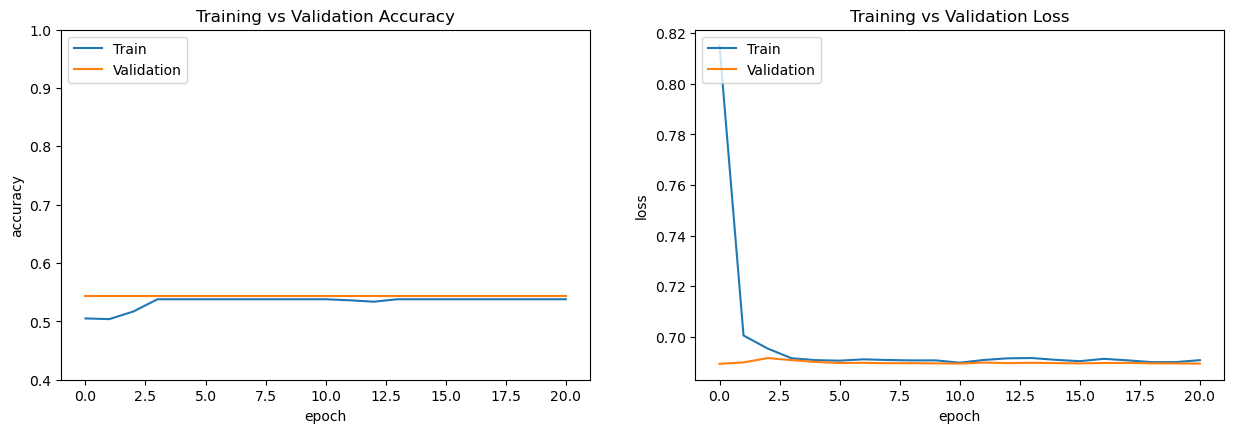

In [12]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

2023-06-22 10:11:07.142141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


343/343 [==============================] - 62s 180ms/step


Text(50.722222222222214, 0.5, 'Real')

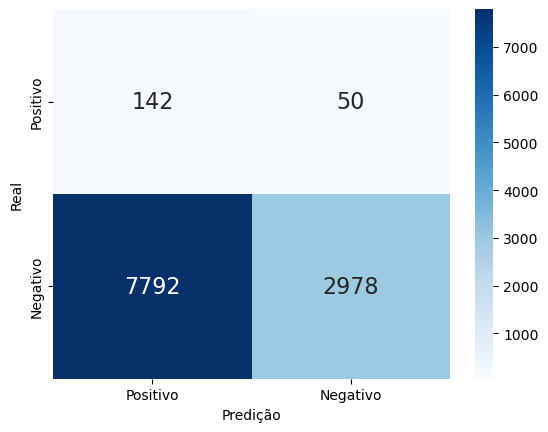

In [32]:
model_resnet50 = load_model('resnet50_undersampling.h5')

pred_resnet50 = model_resnet50.predict(test_generator)

y_pred_resnet50 = []
for prob in pred_resnet50:
    if prob >= 0.5:
        y_pred_resnet50.append(1)
    else:
        y_pred_resnet50.append(0)
        
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_resnet50)

class_names = ['Positivo', 'Negativo']

ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

ax.set_xlabel("Predição")
ax.set_ylabel("Real")